<a href="https://colab.research.google.com/github/digitalhumanitiestextbook/dhtextbook/blob/main/chapter09/9_topic_modeling_practice.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
# 패키지 설치
!pip uninstall numpy scipy gensim pandas -y
!pip install numpy==1.26.4 -qq
!pip install scipy==1.11.4 -qq
!pip install pandas==2.2.2 -qq
!pip install gensim==4.3.2 -qq

In [2]:
# 세션 재실행
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [ ]:
# 패키지 설치
!pip install pyLDAvis -qq
!pip install -qq -U gensim
!pip uninstall spacy thinc -y
!pip install spacy==3.6.1 --no-deps -qq
!pip install thinc==8.1.12 --no-deps -qq
!pip install matplotlib -qq
!pip install seaborn -qq
!python -m spacy download en_core_web_md -qq

- 아래 코드를 실행한 후 나타나는 "파일 선택" 버튼을 클릭하여, 분석할 txt 파일을 업로드하세요.

In [ ]:
from google.colab import files
import os

# 파일 업로드
uploaded = files.upload()

# 업로드한 파일 경로 가져오기
file_path = list(uploaded.keys())[0]
root, ext = os.path.splitext(file_path)
output_file_path = root + '_sentiment_scores.xlsx'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import pyLDAvis.gensim_models
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

sns.set()  # Seaborn 기본 스타일 적용
pyLDAvis.enable_notebook()  # PyLDAvis가 주피터 노트북 내부에 바로 시각화되도록 설정

In [ ]:
# 데이터셋 초기화
import os
import requests

# input, output 폴더 검증
for folder in ["input", "output"]:
    if not os.path.exists(folder):
        os.makedirs(folder)

# 파일 경로와 다운로드 링크
file_path = os.path.join("input", "tm_text.csv")
url = "https://raw.githubusercontent.com/digitalhumanitiestextbook/dhtextbook/main/chapter09/input/tm_text.csv"

# tm_text.csv 파일이 없으면 다운로드
if not os.path.exists(file_path):
    response = requests.get(url)
    response.raise_for_status()  # 오류 발생시 예외처리
    with open(file_path, "wb") as f:
        f.write(response.content)
    print(f"다운로드 완료: {file_path}")
else:
    print(f"이미 존재함: {file_path}")

다운로드 완료: input/tm_text.csv


In [14]:
# 데이터 로드
data = pd.read_csv(file_path, encoding='utf8')
data

,date,text
0,1915.01.01,"To start this diary rightly, it should begin o..."
1,1915.01.02,This is the kind of day which if it were possi...
2,1915.01.03,"It is strange how old traditions, so long buri..."
3,1915.01.04,I do not like the Jewish voice; I do not like ...
4,1915.01.05,"I had a letter this morning from Nessa, who ca..."
...,...,...
1609,1941.02.07,Why was I depressed? I cannot remember.\r\n\r\...
1610,1941.02.16,In the wild grey water after last weeks turmoi...
1611,1941.02.26,My ‘higher life’ is almost entirely the Elizab...
1612,1941.03.08,Just back from L.’s speech at Brighton. Like a...


In [ ]:
# spaCy 모델:
nlp = en_core_web_md.load()

# 글에서 제거하고 싶은 품사태그 입력 (부사(ADV), 대명사(PRON), 접속사(CCONJ), 구두점(PUNCT), 입자(PART), 한정사(DET), 전치사/후치사(ADP), 공백(SPACE), 수사(NUM), 기호(SYM), 동사(VERB), 형용사(ADJ))
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM', 'VERB', 'ADJ']

# 불용어 사용자 설정
custom_stop_words = ['nan', 'nat', 'shall', 'oh', 'mrs', 'mr', 'ms', 's', 'yes', 'shd', 'cd', 'wh', 'wd'] # 사용자가 임의로 지정한 불용어 추가하기
tokens = []

# 'text'열을 스트링으로 전환하여 잠재적으로 누락될 수 있는 값 처리
for text in nlp.pipe(data['text'].astype(str).fillna('')):
   proj_tok = [token.lemma_.lower() for token in text
               if token.pos_ not in removal and
               not token.is_stop and
               token.is_alpha and
               token.lemma_.lower() not in custom_stop_words]
   tokens.append(proj_tok)

In [ ]:
# 토큰화된 결과를 데이터프레임에 추가
data['tokens'] = tokens
data['tokens']

,tokens
0,"[diary, day, year, breakfast, letter, hallett,..."
1,"[kind, day, sample, life, le, grys, appetite, ..."
2,"[tradition, think, hyde, park, gate, sunday, m..."
3,"[voice, laugh, saxon, phrase, flora, woolf, ty..."
4,"[letter, morning, nessa, waterlow, hausfrau, p..."
...,...
1609,"[charlie, chaplin, milk, girl, glow, thrale, c..."
1610,"[water, week, turmoil, dinner, dadie, confiden..."
1611,"[life, elizabethan, play, finished, pointz, ha..."
1612,"[speech, brighton, town, spring, day, woman, s..."


In [ ]:
# 딕셔너리로 각 단어마다 고유 아이디 부여
dictionary = Dictionary(data['tokens'])

# 빈도 기준으로 드문 단어와 너무 흔한 단어 제거 
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

# 코퍼스 생성: 각 문서를 (단어 ID, 단어 빈도) 리스트로 변환
corpus = [dictionary.doc2bow(doc) for doc in data['tokens']]

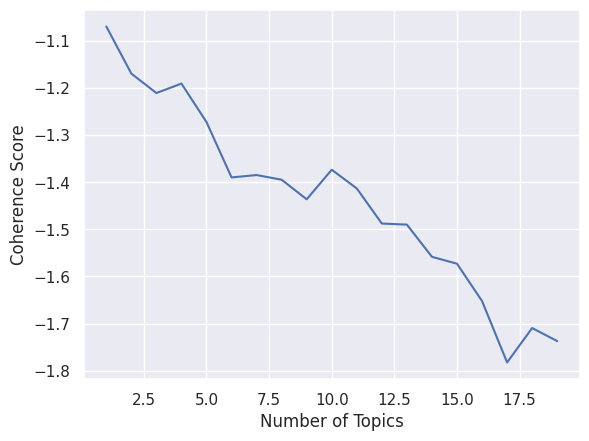

In [ ]:
#C_umass를 이용해서 일관성 점수 구하기
topics = []  # 토픽 개수 기록
score = []  # 각 토픽 개수별 Coherence Score 기록

# 토픽 개수를 1부터 19까지 변화시키며 평가
for i in range(1, 20):
   # LDA 모델 학습
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=15, random_state=0)
   
   # CoherenceModel로 토픽 일관성 평가
   coh_model = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')

   # 토픽 개수 및 점수 저장
   topics.append(i)
   score.append(coh_model.get_coherence())

# 토픽 개수 vs Coherence Score 시각화
plt.plot(topics, score)  # 토픽 개수에 따른 Coherence Score 곡선 그리기
plt.xlabel('Number of Topics')  # x축 레이블 설정
plt.ylabel('Coherence Score')  # y축 레이블 설정
plt.show()  # 그래프 출력

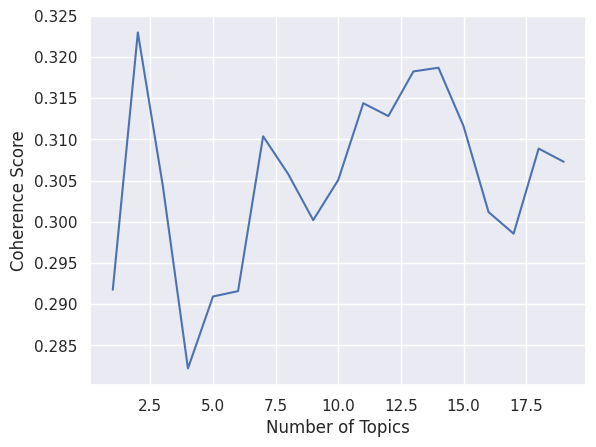

In [ ]:
#c_v를 사용해서 일관성 점수 구하기
topics = []  # 토픽 개수 기록
score = []  # 각 토픽 개수별 Coherence Score 기록

# 토픽 개수를 1부터 19까지 변화시키며 평가
for i in range(1, 20):
   # LDA 모델 학습
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=15, random_state=0)

   # CoherenceModel로 토픽 일관성 평가
   coh_model = CoherenceModel(model=lda_model, texts=data['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   
   # 토픽 개수 및 점수 저장
   topics.append(i)
   score.append(coh_model.get_coherence())

# 토픽 개수 vs Coherence Score 시각화
plt.plot(topics, score)  # 토픽 개수에 따른 Coherence Score 곡선 그리기
plt.xlabel('Number of Topics')  # x축 레이블 설정
plt.ylabel('Coherence Score')  # y축 레이블 설정
plt.show()  # 그래프 출력

In [ ]:
# LDA 모델 학습
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, random_state=0, passes=15)

# 학습된 모델의 모든 토픽 출력
lda_model.print_topics(-1)

[(0,
  '0.022*"clive" + 0.019*"nessa" + 0.018*"man" + 0.017*"night" + 0.013*"life" + 0.012*"woman" + 0.010*"year" + 0.010*"time" + 0.009*"maynard" + 0.008*"room"'),
 (1,
  '0.025*"week" + 0.017*"yesterday" + 0.015*"morning" + 0.014*"letter" + 0.013*"today" + 0.013*"lytton" + 0.012*"night" + 0.012*"tea" + 0.011*"time" + 0.011*"people"'),
 (2,
  '0.020*"life" + 0.017*"way" + 0.017*"thing" + 0.014*"time" + 0.013*"year" + 0.013*"morning" + 0.012*"mind" + 0.011*"feeling" + 0.011*"people" + 0.010*"letter"'),
 (3,
  '0.018*"people" + 0.013*"man" + 0.012*"time" + 0.012*"desmond" + 0.012*"story" + 0.011*"tea" + 0.010*"thing" + 0.009*"murry" + 0.009*"eye" + 0.008*"letter"'),
 (4,
  '0.017*"morning" + 0.013*"time" + 0.013*"week" + 0.011*"yesterday" + 0.011*"way" + 0.011*"letter" + 0.010*"room" + 0.010*"today" + 0.010*"roger" + 0.009*"thing"'),
 (5,
  '0.016*"london" + 0.016*"man" + 0.015*"night" + 0.014*"house" + 0.012*"street" + 0.011*"people" + 0.009*"nessa" + 0.009*"roger" + 0.009*"yesterday" 

In [15]:
#시각화 생성
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

# 시각화 저장
pyLDAvis.save_html(lda_display, 'output/index.html')

In [ ]:
# Google Colab 환경에서 생성된 HTML 파일을 로컬로 다운로드
from google.colab import files

files.download("output/index.html")

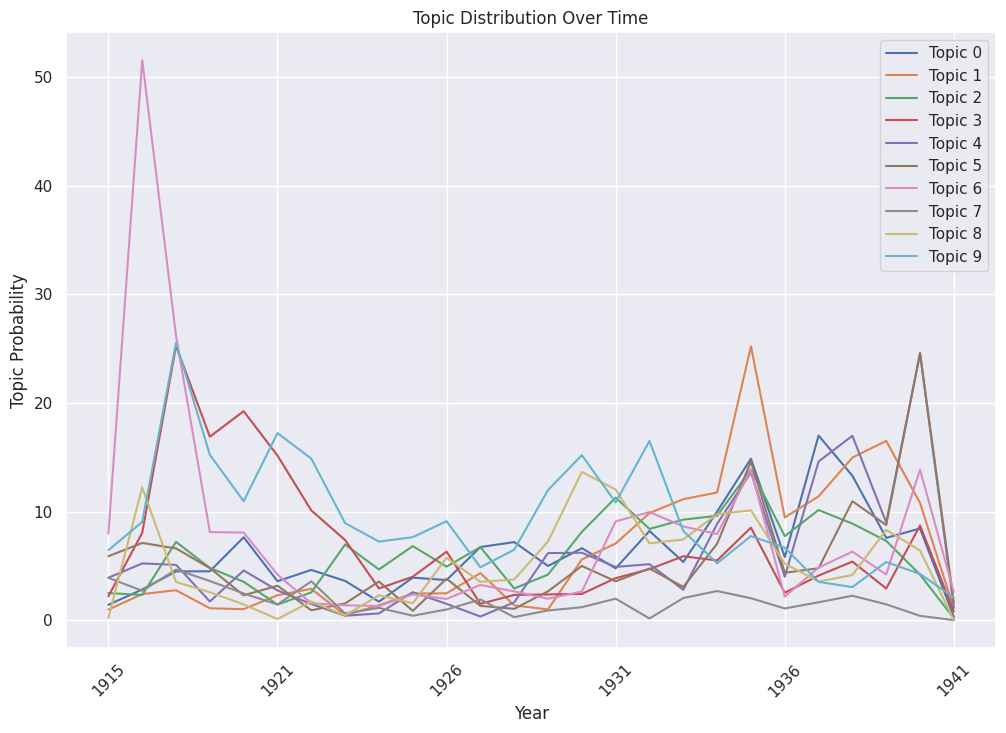

In [ ]:
import matplotlib.pyplot as plt

# data 행에서 년도만 추출
data['year'] = data['date'].apply(lambda x: x.split('.')[0])

# 각 문서별 토픽 분포 계산
topic_dist = lda_model[corpus]

# 각 년도별로 토픽 분포를 저장하는 딕셔너리 생성
topic_dist_per_year = {}
for i, doc in enumerate(topic_dist):
    year = data['year'][i]  # 현재 문서의 연도
    if year not in topic_dist_per_year:
        topic_dist_per_year[year] = {}  # 연도별 토픽 딕셔너리 초기화

    # 문서 내 (토픽ID, 확률) 쌍 반복
    for topic_id, prob in doc:
        if topic_id not in topic_dist_per_year[year]:
            topic_dist_per_year[year][topic_id] = 0  # 해당 토픽 초기화
        topic_dist_per_year[year][topic_id] += prob  # 해당 연도의 해당 토픽 확률 누적

# 그래프 위한 데이터 준비
years = sorted(topic_dist_per_year.keys())
topic_probs = {topic_id: [topic_dist_per_year[year].get(topic_id, 0) for year in years] for topic_id in range(lda_model.num_topics)}

# Plot the topic distributions over time 그래프 위한 데이터 준비
plt.figure(figsize=(12, 8))
# 연도별 토픽 확률 변화 시각화
for topic_id, probs in topic_probs.items():
    plt.plot(years, probs, label=f'Topic {topic_id}')

# 그래프 라벨, 제목, 범례 설정
plt.xticks(ticks=range(0, len(years), 5), labels=[years[i] for i in range(0, len(years), 5)], rotation=45)  # x축 눈금 및 레이블 설정
plt.xlabel('Year')  # x축 레이블 설정
plt.ylabel('Topic Probability')  # y축 레이블 설정
plt.title('Topic Distribution Over Time')  # 그래프 제목 설정
plt.legend()  # 범례 표시
plt.show()  # 그래프 출력

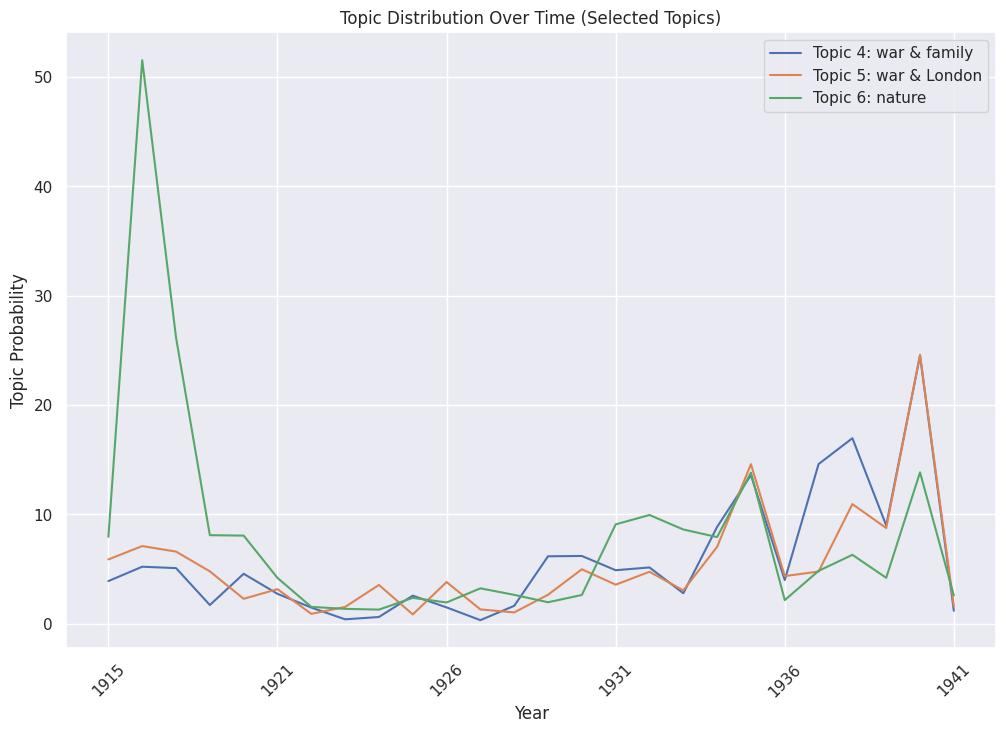

In [ ]:
#선택한 토픽만 그래프로 그리기
selected_topics = {
    4: 'war & family',
    5: 'war & London',
    6: 'nature',
}

plt.figure(figsize=(12, 8))

# 선택한 토픽별로 연도별 확률 변화 그리기
for topic_id, topic_name in selected_topics.items():
    if topic_id in topic_probs:
        # years: x축(연도), topic_probs[topic_id]: y축(해당 토픽의 연도별 확률)
        plt.plot(years, topic_probs[topic_id], label=f'Topic {topic_id}: {topic_name}')
    else:
        # 선택한 토픽이 topic_probs에 없으면 경고 출력
        print(f"Warning: Topic {topic_id} not found in topic_probs")

# X축 눈금을 5년 간격으로 설정하고 라벨 회전
plt.xticks(ticks=range(0, len(years), 5), labels=[years[i] for i in range(0, len(years), 5)], rotation=45)

# 그래프 라벨, 제목, 범례 설정
plt.xlabel('Year')  # x축 레이블 설정
plt.ylabel('Topic Probability')  # y축 레이블 설정
plt.title('Topic Distribution Over Time (Selected Topics)')  # 그래프 제목 설정
plt.legend()  # 범례 표시
plt.show()  # 그래프 출력

In [ ]:
def make_topictable(lda_model, corpus):
    topic_table = pd.DataFrame()  # 결과를 저장할 빈 DataFrame 생성

    # 각 문서별 토픽 분포 계산
    for i, topic_dist in enumerate(lda_model[corpus]):
        # ldamodel.per_word_topics가 True면 topic_list[0]을 fasle면 topic_list 전체를 할당
        doc = topic_dist[0] if lda_model.per_word_topics else topic_dist

        # 각 문서에 대해 가장 비중이 높은 토픽 찾기
        if doc:  # 토픽 분포가 비어있지 않은 경우
            top_topic, weight = max(doc, key=lambda x: x[1]) # (토픽 ID, 확률) 중 확률이 가장 높은 것
            new_row = pd.DataFrame([pd.Series([int(top_topic), round(weight, 4), topic_dist])]) # 새 행 생성: [가장 높은 토픽 ID, 그 토픽의 비중, 전체 토픽 분포]
            topic_table = pd.concat([topic_table, new_row], ignore_index=True) # 기존 topic_table에 행 추가

    return topic_table

In [ ]:
topictable = make_topictable(lda_model, corpus)  # 토픽 테이블 생성
topictable = topictable.reset_index()  # 문서 번호를 의미하는 열로 사용하기 위해 인덱스를 추가
topictable.columns = ['문서 번호', '가장 비중이 높은 토픽', '가장 높은 토픽의 비중', '각 토픽의 비중']  # 각 열의 의미를 명확히 지정
topictable[:1614]  # 상위 1614개 문서의 토픽 정보 확인

,문서 번호,가장 비중이 높은 토픽,가장 높은 토픽의 비중,각 토픽의 비중
0,0,9,0.4857,"[(7, 0.48466483), (9, 0.48569456)]"
1,1,6,0.9816,"[(6, 0.98162574)]"
2,2,5,0.4234,"[(1, 0.30730265), (5, 0.4234306), (7, 0.254976..."
3,3,6,0.6875,"[(3, 0.29679707), (6, 0.68751067)]"
4,4,6,0.4313,"[(3, 0.37960947), (6, 0.431258), (9, 0.17801681)]"
...,...,...,...,...
1609,1609,5,0.8649,"[(1, 0.11347319), (5, 0.86489826)]"
1610,1610,6,0.5736,"[(1, 0.3122695), (6, 0.573586), (9, 0.094136804)]"
1611,1611,9,0.7077,"[(5, 0.28013048), (9, 0.70774376)]"
1612,1612,9,0.3363,"[(3, 0.3242117), (5, 0.16825722), (6, 0.157906..."


In [ ]:
from google.colab import files
topictable.to_csv("output/topictable.csv", index=False)
files.download('output/topictable.csv')